# Neural networks and images

Inspiration for this notebook is taken from YSDA materials

### About CNNs
Convolutional layers extract features - quantitative representations of some attributes. 

After the extraction you can use these features for classification, for example.

<img src="img/act.png" width="800">

#### Convolution:
<img src="img/convolution.gif" width="400">

### Pooling:
<img src="img/pooling.gif" width="400">


## Let's look at popular architectures.

### VGG

<img src="img/vgg.png" width="600">

### ResNet (Shortcut + Batch Normalization)
 
<img src="img/resnet.png" width="800">
 
### GoogleNet (Predict classes for many times)
 
<img src="img/gln.png" width="800">


## Deeper layer $\to$ more complex features.

<img src="img/feat.png" width="800">

# Task: Cats vs. Dogs Classification

<img src="img/cat_dog_sota.jpg" width="600">




Let's try to build a small convolutional neural network capable of separating cat images from dog images.

#### Google Colab Stuff

In [1]:
# Colab users only
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Datasets in pyTorch

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

- For images, packages such as *Pillow*, *OpenCV* are useful
- For audio, packages such as *scipy* and *librosa*
- For text, either raw *Python* or *Cython* based loading, or *NLTK* and *SpaCy* are useful

We are dealing with images, so let's have a look at image data loading in pyTorch for [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) classification competition.

The link for data downloading is in the cell below.

Training set size is reduced for performace. If you have enough computational resources, use [this link](https://www.dropbox.com/s/h2vhfxb0j3eazu1/train.zip) for downloading. 

In [ ]:
!wget https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
!unzip data.zip -d data


Now let's look at the way datasets are processed in pyTorch.

In [1]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Images should be stored class-wise in PC memory: each image class have to be represented as a subfolder with the corresponding image data. `ImageFolder` takes the path to 'root' directory of such structure, e.g. DATA_PATH:

- DATA_PATH/dog/xxx.png
- DATA_PATH/dog/xxy.png
- DATA_PATH/dog/xxz.png
- DATA_PATH/cat/123.png
- DATA_PATH/cat/nsdf3.png
- DATA_PATH/cat/asd932_.png

Dataset images are of different size.

Batch generator expects a batch of tensors of the same dimensions, thus we need to rescale images in the dataset during data loading.

Let's see at the image size distributions.

In [1]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = r"data" # PATH TO THE DATASET

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 96

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 128

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

Let's define a transformer to be used as image preprocessing step prior to creating pyTorch image dataset

In [3]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

Create an ImageFolder instance to be used during training, validation and testing phases.

In [4]:
# load dataset using torchvision.datasets.ImageFolder
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train_11k'), transform=transformer)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)

In [5]:
# load test data also, to be used for final evaluation
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test_labeled'), transform=transformer)

Save sample num for further use

In [6]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)

Now let's create a DataLoader instance, which uses ImageFolder instance to generate batches of data.

In [7]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

In [8]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            num_workers=NUM_WORKERS)

In [9]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             num_workers=NUM_WORKERS)

Let's create a helper function to vizualize images from our data loaders.

In [10]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

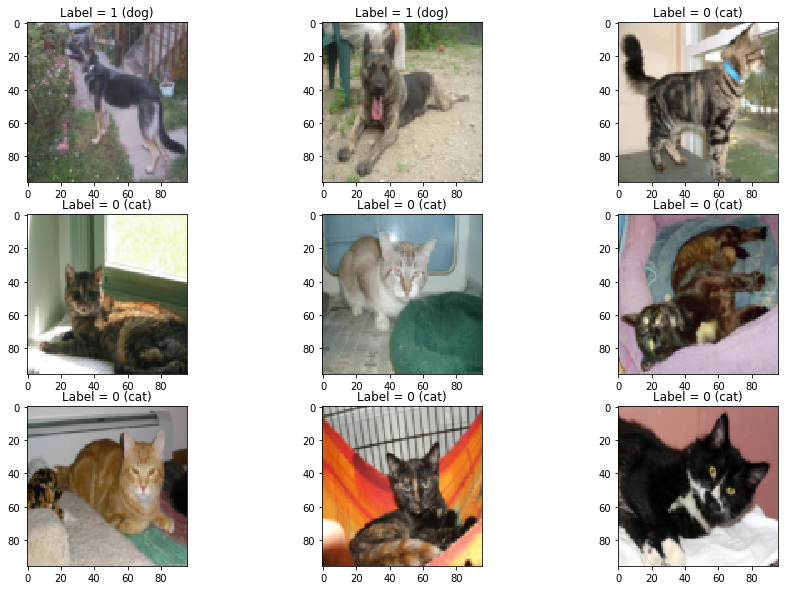

In [0]:
plot_from_batch_generator(train_batch_gen)

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.
Let's use them to create a baseline for our models

In [11]:
# a special module that converts [batch, channel, w, h] to [batch, units]: tf/keras style
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [12]:
def compute_loss(model, X_batch, y_batch):
    logits = model(X_batch)
    return ## CROSSENTROPY LOSS

Prepare separate functions for model training and evaluation

In [13]:
def train_model(model, train_batch_generator, val_batch_generator, opt, ckpt_name=None, n_epochs=EPOCH_NUM):
    train_loss = []
    val_accuracy = []
    best_model = None
    top_val_accuracy = 0
    
    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Training'):
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            # YOUR CODE HERE
            train_loss.append(loss.cpu().data.numpy())

        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in val_batch_generator:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        # print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time))
        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100
        
        if val_accuracy_value > top_val_accuracy and ckpt_name is not None:
            top_val_accuracy = val_accuracy_value
            # print('top val accuracy: %.3f' % top_val_accuracy)
            # save checkpoint of the best model to disk
            with open(ckpt_name, 'wb') as f: torch.save(model, f)
        
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss_value))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy_value))
        custom_objects = (train_loss, val_accuracy)
        
    return best_model, opt, custom_objects

def test_model(model, test_batch_generator, subset='test'):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in test_batch_generator:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    test_accuracy = np.mean(test_batch_acc)
    
    print("Results:")
    print("  {} accuracy:\t\t{:.2f} %".format(subset, test_accuracy * 100))
    if test_accuracy * 100 > 90:
        print("Amazing!")
    elif test_accuracy * 100 > 70:
        print("Good!")
    else:
        print("We need more magic! Follow instructons below")
    return test_accuracy

## Task 0: Multi-layer fully-connected network

Look at the CNN structure proposed below.

We will use this model as a baseline for classification task.

As you already know, fully-connetcted networks are not translation invariant and perform worse on image data, so resulting accuracy will be lower than for convolutional neural networks.

In [0]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * SIZE_H * SIZE_W, 256))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dropout1', nn.Dropout(0.05))
model.add_module('dense3', nn.Linear(256, 128))
model.add_module('dense3_relu', nn.ReLU())
model.add_module('dropout3', nn.Dropout(0.05))
model.add_module('dense4_logits', nn.Linear(128, NUM_CLASSES)) # logits for NUM_CLASSES=2: cats and dogs
model.add_module('dense4_preds', nn.Sigmoid())                 # predictions for NUM_CLASSES=2: cats and dogs

model = model.to(device)

Print model summary for sanity check:

In [30]:
summary(model, (3, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 27648]               0
            Linear-2                  [-1, 256]       7,078,144
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                    [-1, 2]             258
           Sigmoid-9                    [-1, 2]               0
Total params: 7,111,298
Trainable params: 7,111,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.22
Params size (MB): 27.13
Estimated Total Size (MB): 27.45
-------------------------------------

Define a loss function to be optimized during training.

### Training on minibatches
* We got 11k images (22k for full train set), that's way too many for a full-batch SGD. Let's train on minibatches instead

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
opt.zero_grad()
ckpt_name = 'model_base.ckpt'
model, opt, custom_objects = train_model(model, train_batch_gen, val_batch_gen, opt, ckpt_name=ckpt_name)

Epoch 1 of 30 took 27.209s


C:\Users\y.efimov\miniconda3\envs\py36\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


  training loss (in-iteration): 	0.662673
  validation accuracy: 			59.76 %
Epoch 2 of 30 took 27.359s
  training loss (in-iteration): 	0.635062
  validation accuracy: 			61.23 %
Epoch 3 of 30 took 27.157s
  training loss (in-iteration): 	0.610454
  validation accuracy: 			61.79 %
Epoch 4 of 30 took 26.472s
  training loss (in-iteration): 	0.590780
  validation accuracy: 			63.60 %
Epoch 5 of 30 took 27.262s
  training loss (in-iteration): 	0.568076
  validation accuracy: 			63.76 %
Epoch 6 of 30 took 28.311s
  training loss (in-iteration): 	0.545202
  validation accuracy: 			63.10 %
Epoch 7 of 30 took 26.865s
  training loss (in-iteration): 	0.534504
  validation accuracy: 			63.89 %
Epoch 8 of 30 took 25.835s
  training loss (in-iteration): 	0.516244
  validation accuracy: 			63.84 %
Epoch 9 of 30 took 25.689s
  training loss (in-iteration): 	0.503965
  validation accuracy: 			64.18 %
Epoch 10 of 30 took 25.853s
  training loss (in-iteration): 	0.489904
  validation accuracy: 			64.5

Don't wait for too many epochs. You can interrupt training after 5-15 epochs once validation accuracy stops going up.
```

```

```

```

```

```

### Evaluate the best model using test set

In [0]:
best_model = None
with open(ckpt_name, 'rb') as f:
    best_model = torch.load(f)

val_acc = test_model(best_model, val_batch_gen, 'val')
test_acc = test_model(best_model, test_batch_gen, 'test')

Results:
  val accuracy:		65.68 %
We need more magic! Follow instructons below
Results:
  test accuracy:		67.51 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

**conv-pool-conv-pool-dense-dense-everybody!**

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3 classic convolutional blocks `convolution->relu->pool`: 
  * 3x3 convolution with 128 filters and _ReLU_ activation
  * 2x2 pooling (or set previous convolution stride to 3)
 * Flatten
* 30% Dropout 
* Dense layer with 256 neurons and _ReLU_ activation
* 30% dropout
* Output dense layer.

__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with learning_rate=3e-4 (Karpathy Constant)

If everything is right, you should get at least __75%__ validation accuracy.

__HACK_OF_THE_DAY__ :the number of channels must be in the order of the number of class_labels

__HACK_OF_THE_DAY_2__ : you may set stride=2 for Conv2d layers to increase learning speed, but keep in mind tensor shapes

In [0]:
model_cnn = nn.Sequential()

# Your code here: CONV->POOL->CONV-POOL->... as many as you wish

# End of your code here
# global average pooling
model_cnn.add_module('gap_5', nn.AvgPool2d(20))
# dropout for regularization
model_cnn.add_module('dropout_5', nn.Dropout(0.3))
# "flatten" the data
model_cnn.add_module('flat', Flatten())
# last fully-connected layer, used to create embedding vectors
model_cnn.add_module('fc_6', nn.Linear(128, EMBEDDING_SIZE))
model_cnn.add_module('relu_6', nn.ReLU())

model_cnn.add_module('dropout_6', nn.Dropout(0.3))

# logits for NUM_CLASSES=2 classes
model_cnn.add_module('fc_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES))
model_cnn.add_module('fc_preds', nn.Sigmoid())

# move model to computing device
model_cnn = model_cnn.to(device)


__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

Let's see the basic structure of our model and at the same time perform a sanity check for tensor dimensions.

In [0]:
summary(model_cnn, (3, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 94]             896
              ReLU-2           [-1, 32, 94, 94]               0
         MaxPool2d-3           [-1, 32, 47, 47]               0
            Conv2d-4           [-1, 64, 45, 45]          18,496
              ReLU-5           [-1, 64, 45, 45]               0
         MaxPool2d-6           [-1, 64, 22, 22]               0
            Conv2d-7          [-1, 128, 20, 20]          73,856
              ReLU-8          [-1, 128, 20, 20]               0
         AvgPool2d-9            [-1, 128, 1, 1]               0
          Dropout-10            [-1, 128, 1, 1]               0
          Flatten-11                  [-1, 128]               0
           Linear-12                  [-1, 256]          33,024
             ReLU-13                  [-1, 256]               0
          Dropout-14                  [

#### Training

In [0]:
opt = torch.optim.Adam(model_cnn.parameters(), lr=3e-4)
opt.zero_grad()
ckpt_name_cnn='model_cnn.ckpt'
model_cnn, opt, custom_objects_cnn = train_model(model_cnn,
                                                 train_batch_gen,
                                                 val_batch_gen,
                                                 opt,
                                                 ckpt_name=ckpt_name_cnn)

Epoch 1 of 30 took 26.082s
  training loss (in-iteration): 	0.673040
  validation accuracy: 			61.27 %
Epoch 2 of 30 took 26.069s
  training loss (in-iteration): 	0.649259
  validation accuracy: 			61.74 %
Epoch 3 of 30 took 26.253s
  training loss (in-iteration): 	0.641381
  validation accuracy: 			61.92 %
Epoch 4 of 30 took 26.496s
  training loss (in-iteration): 	0.635348
  validation accuracy: 			60.35 %
Epoch 5 of 30 took 25.980s
  training loss (in-iteration): 	0.632899
  validation accuracy: 			63.83 %
Epoch 6 of 30 took 26.034s
  training loss (in-iteration): 	0.627744
  validation accuracy: 			62.31 %
Epoch 7 of 30 took 25.939s
  training loss (in-iteration): 	0.621497
  validation accuracy: 			64.69 %
Epoch 8 of 30 took 26.313s
  training loss (in-iteration): 	0.615330
  validation accuracy: 			62.44 %
Epoch 9 of 30 took 26.371s
  training loss (in-iteration): 	0.609131
  validation accuracy: 			59.14 %
Epoch 10 of 30 took 25.913s
  training loss (in-iteration): 	0.602371
  v

**A kind reminder again:** don't wait for too many  epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```
```
#### Evaluation 


In [0]:
best_model_cnn = None
with open(ckpt_name_cnn, 'rb') as f:
    best_model_cnn = torch.load(f)

val_accuracy = test_model(best_model_cnn, val_batch_gen, subset='val')
test_accuracy = test_model(best_model_cnn, test_batch_gen, subset='test')

Results:
  val accuracy:		75.36 %
Good!
Results:
  test accuracy:		77.68 %
Good!


```
```


## Task 2: adding normalization and different model initialization

* Improve the previous CNN architecture  with the following:
  * Add batch norm (with default params) between convolution and ReLU
    * nn.BatchNorm*d (1d for dense, 2d for conv)
    * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least __80%__ validation accuracy at peak.
* Use the following model class to simplify the inference


To know more about **batch_norm** and **data covariate shift**

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

https://www.youtube.com/watch?v=nUUqwaxLnWs

In [14]:
# Custom model class

def conv_block_3x3(in_channels, out_channels, stride=1):
    return nn.Sequential(
    # YOUR CODE HERE
    # CONV 3x3 -> BN -> ReLU
    # YOUR CODE ENDS HERE
  )


class MyModel(torch.nn.Module):
    def __init__(self, in_feature):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            ## YOUR CODE HERE: repeat the same architecture as above, using conv_block_3x3
        )
        self.fc = nn.Sequential(
            # YOUR CODE HERE: FC->BN->RELU
        )
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.pred(x)
        return x

In [15]:
# outputs are here for convenience
model_cnn_norm = MyModel(3).to(device)
summary(model_cnn_norm, (3, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             864
       BatchNorm2d-2           [-1, 32, 96, 96]              64
              ReLU-3           [-1, 32, 96, 96]               0
         MaxPool2d-4           [-1, 32, 48, 48]               0
            Conv2d-5           [-1, 64, 48, 48]          18,432
       BatchNorm2d-6           [-1, 64, 48, 48]             128
              ReLU-7           [-1, 64, 48, 48]               0
         MaxPool2d-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]          73,728
      BatchNorm2d-10          [-1, 128, 24, 24]             256
             ReLU-11          [-1, 128, 24, 24]               0
        AvgPool2d-12            [-1, 128, 1, 1]               0
          Flatten-13                  [-1, 128]               0
           Linear-14                  [

#### Training

In [0]:
opt = torch.optim.Adam(model_cnn_norm.parameters(), lr=3e-4)
ckpt_name_cnn_norm='model_cnn_norm.ckpt'
model_cnn_norm, opt, custom_objects_cnn_norm = train_model(model_cnn_norm,
                                                           train_batch_gen,
                                                           val_batch_gen,
                                                           opt,
                                                           ckpt_name=ckpt_name_cnn_norm)

Epoch 1 of 30 took 26.778s


C:\Users\y.efimov\miniconda3\envs\py36\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type MyModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


  training loss (in-iteration): 	0.646143
  validation accuracy: 			60.45 %
Epoch 2 of 30 took 27.207s
  training loss (in-iteration): 	0.600622
  validation accuracy: 			66.72 %
Epoch 3 of 30 took 26.728s
  training loss (in-iteration): 	0.575930
  validation accuracy: 			60.72 %
Epoch 4 of 30 took 25.942s
  training loss (in-iteration): 	0.560624
  validation accuracy: 			65.40 %
Epoch 5 of 30 took 25.957s
  training loss (in-iteration): 	0.545514
  validation accuracy: 			70.39 %
Epoch 6 of 30 took 26.155s
  training loss (in-iteration): 	0.540951
  validation accuracy: 			53.13 %
Epoch 7 of 30 took 26.026s
  training loss (in-iteration): 	0.536733
  validation accuracy: 			72.70 %
Epoch 8 of 30 took 26.121s
  training loss (in-iteration): 	0.524859
  validation accuracy: 			69.87 %
Epoch 9 of 30 took 26.117s
  training loss (in-iteration): 	0.519827
  validation accuracy: 			62.56 %
Epoch 10 of 30 took 26.007s
  training loss (in-iteration): 	0.517709
  validation accuracy: 			74.9

#### Evaluation

In [0]:
best_model_cnn_norm = None
with open(ckpt_name_cnn_norm, 'rb') as f:
    best_model_cnn_norm = torch.load(f)
test_model(best_model_cnn_norm, val_batch_gen, subset='val')
test_model(best_model_cnn_norm, test_batch_gen, subset='test')

Results:
  val accuracy:		80.09 %
Good!
Results:
  test accuracy:		81.19 %
Good!


0.8119378761119833


```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly changes image color (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

<img src="img/augmentation.png" width="500">

In [28]:
transformer_augmented = transforms.Compose([
    # YOUR CODE HERE
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)]
)

In [29]:
# Load dataset using ImageFolder using transformer with augmentation
# Note: We do not use augmentation for validation or testing
train_dataset_aug = # YOUR CODE HERE: creade dataset using the transformer above
train_aug_batch_gen = torch.utils.data.DataLoader(train_dataset_aug, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

Let's look at some image examples

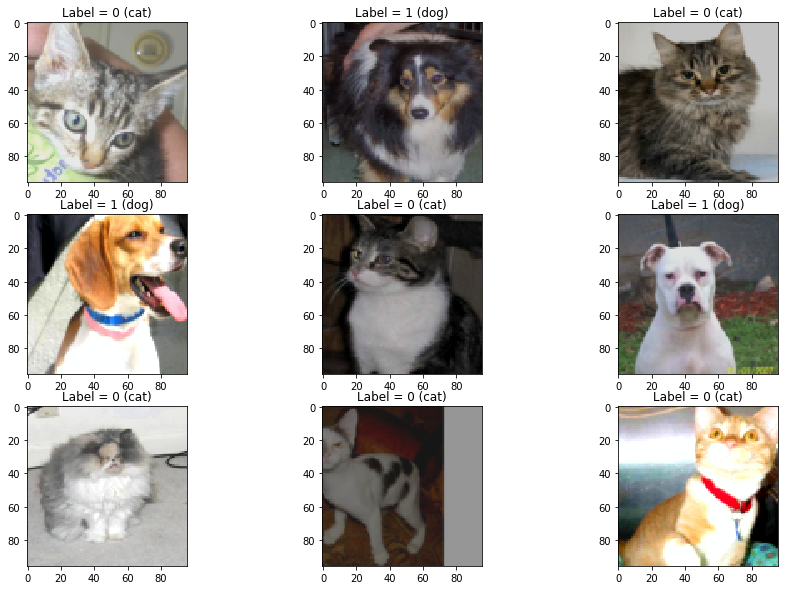

In [30]:
plot_from_batch_generator(train_aug_batch_gen)

Note that we did not change test_dataset, as we do not need to augment image data in it. 

Let's retrain our model, saving it to another variable

#### Training

In [31]:
model_cnn_aug = MyModel(3).to(device)
opt = torch.optim.Adam(model_cnn_aug.parameters(), lr=3e-4)
ckpt_name_aug='model_cnn_aug.ckpt'
model_cnn_aug, opt, custom_objects_cnn_aug = train_model(model_cnn_aug,
                                                          train_aug_batch_gen,
                                                          val_batch_gen,
                                                          opt,
                                                          ckpt_name=ckpt_name_aug,
                                                          n_epochs=2 * EPOCH_NUM)

Epoch 1 of 60 took 26.469s
  training loss (in-iteration): 	0.649181
  validation accuracy: 			64.87 %


Epoch 2 of 60 took 27.837s
  training loss (in-iteration): 	0.609101
  validation accuracy: 			67.19 %


Epoch 3 of 60 took 30.614s
  training loss (in-iteration): 	0.581289
  validation accuracy: 			60.35 %


Epoch 4 of 60 took 29.933s
  training loss (in-iteration): 	0.562234
  validation accuracy: 			70.47 %


Epoch 5 of 60 took 30.562s
  training loss (in-iteration): 	0.544247
  validation accuracy: 			66.52 %


Epoch 6 of 60 took 31.510s
  training loss (in-iteration): 	0.544884
  validation accuracy: 			72.70 %


Epoch 7 of 60 took 32.069s
  training loss (in-iteration): 	0.539529
  validation accuracy: 			69.62 %


Epoch 8 of 60 took 31.999s
  training loss (in-iteration): 	0.539279
  validation accuracy: 			71.73 %


Epoch 9 of 60 took 33.473s
  training loss (in-iteration): 	0.526327
  validation accuracy: 			69.69 %


Epoch 10 of 60 took 35.439s
  training loss (in-iteration): 	0.523084
  validation accuracy: 			64.34 %


Epoch 11 of 60 took 33.915s
  training loss (in-iteration): 	0.520394
  validation accuracy: 			71.46 %


Epoch 12 of 60 took 34.755s
  training loss (in-iteration): 	0.517560
  validation accuracy: 			76.09 %


Epoch 13 of 60 took 33.331s
  training loss (in-iteration): 	0.513805
  validation accuracy: 			67.37 %


Epoch 14 of 60 took 32.901s
  training loss (in-iteration): 	0.515843
  validation accuracy: 			67.17 %


Epoch 15 of 60 took 33.097s
  training loss (in-iteration): 	0.511571
  validation accuracy: 			60.44 %


Epoch 16 of 60 took 34.883s
  training loss (in-iteration): 	0.506434
  validation accuracy: 			67.12 %


Epoch 17 of 60 took 34.709s
  training loss (in-iteration): 	0.511949
  validation accuracy: 			73.46 %


Epoch 18 of 60 took 33.951s
  training loss (in-iteration): 	0.504693
  validation accuracy: 			70.07 %


Epoch 19 of 60 took 33.547s
  training loss (in-iteration): 	0.502753
  validation accuracy: 			77.08 %


Epoch 20 of 60 took 30.819s
  training loss (in-iteration): 	0.500972
  validation accuracy: 			70.65 %


Epoch 21 of 60 took 29.638s
  training loss (in-iteration): 	0.498566
  validation accuracy: 			73.22 %


Epoch 22 of 60 took 29.462s
  training loss (in-iteration): 	0.490839
  validation accuracy: 			78.61 %


Epoch 23 of 60 took 29.370s
  training loss (in-iteration): 	0.491065
  validation accuracy: 			66.68 %


Epoch 24 of 60 took 29.963s
  training loss (in-iteration): 	0.488873
  validation accuracy: 			79.24 %


Epoch 25 of 60 took 29.825s
  training loss (in-iteration): 	0.486347
  validation accuracy: 			75.51 %


Epoch 26 of 60 took 29.512s
  training loss (in-iteration): 	0.488708
  validation accuracy: 			78.71 %


Epoch 27 of 60 took 29.477s
  training loss (in-iteration): 	0.486134
  validation accuracy: 			65.92 %


Epoch 28 of 60 took 30.117s
  training loss (in-iteration): 	0.478633
  validation accuracy: 			75.26 %


Epoch 29 of 60 took 30.166s
  training loss (in-iteration): 	0.479319
  validation accuracy: 			76.36 %


Epoch 30 of 60 took 29.903s
  training loss (in-iteration): 	0.478052
  validation accuracy: 			72.60 %


Epoch 31 of 60 took 29.819s
  training loss (in-iteration): 	0.482705
  validation accuracy: 			78.86 %


Epoch 32 of 60 took 31.468s
  training loss (in-iteration): 	0.478502
  validation accuracy: 			68.97 %


Epoch 33 of 60 took 30.788s
  training loss (in-iteration): 	0.478564
  validation accuracy: 			73.89 %


Epoch 34 of 60 took 30.370s
  training loss (in-iteration): 	0.471492
  validation accuracy: 			80.41 %


Epoch 35 of 60 took 30.454s
  training loss (in-iteration): 	0.473973
  validation accuracy: 			64.01 %


Epoch 36 of 60 took 29.984s
  training loss (in-iteration): 	0.465778
  validation accuracy: 			80.69 %


Epoch 37 of 60 took 29.911s
  training loss (in-iteration): 	0.472161
  validation accuracy: 			62.23 %


Epoch 38 of 60 took 29.849s
  training loss (in-iteration): 	0.465337
  validation accuracy: 			79.46 %


Epoch 39 of 60 took 30.050s
  training loss (in-iteration): 	0.472403
  validation accuracy: 			78.01 %


Epoch 40 of 60 took 29.881s
  training loss (in-iteration): 	0.468584
  validation accuracy: 			78.51 %


Epoch 41 of 60 took 29.805s
  training loss (in-iteration): 	0.462931
  validation accuracy: 			68.85 %


Epoch 42 of 60 took 29.794s
  training loss (in-iteration): 	0.458812
  validation accuracy: 			81.54 %


Epoch 43 of 60 took 29.849s
  training loss (in-iteration): 	0.458634
  validation accuracy: 			74.08 %


Epoch 44 of 60 took 29.559s
  training loss (in-iteration): 	0.459156
  validation accuracy: 			78.77 %


Epoch 45 of 60 took 29.338s
  training loss (in-iteration): 	0.455286
  validation accuracy: 			81.41 %


Epoch 46 of 60 took 29.334s
  training loss (in-iteration): 	0.456708
  validation accuracy: 			78.97 %


Epoch 47 of 60 took 29.449s
  training loss (in-iteration): 	0.452864
  validation accuracy: 			83.01 %


Epoch 48 of 60 took 29.372s
  training loss (in-iteration): 	0.454250
  validation accuracy: 			81.93 %


Epoch 49 of 60 took 29.291s
  training loss (in-iteration): 	0.450649
  validation accuracy: 			60.79 %


Epoch 50 of 60 took 29.359s
  training loss (in-iteration): 	0.451192
  validation accuracy: 			79.29 %


Epoch 51 of 60 took 29.319s
  training loss (in-iteration): 	0.449465
  validation accuracy: 			70.37 %


Epoch 52 of 60 took 29.329s
  training loss (in-iteration): 	0.449424
  validation accuracy: 			83.12 %


Epoch 53 of 60 took 29.436s
  training loss (in-iteration): 	0.454309
  validation accuracy: 			69.90 %


Epoch 54 of 60 took 29.323s
  training loss (in-iteration): 	0.444872
  validation accuracy: 			83.76 %


Epoch 55 of 60 took 29.317s
  training loss (in-iteration): 	0.449371
  validation accuracy: 			81.70 %


Epoch 56 of 60 took 29.360s
  training loss (in-iteration): 	0.447447
  validation accuracy: 			82.26 %


Epoch 57 of 60 took 29.338s
  training loss (in-iteration): 	0.445482
  validation accuracy: 			62.92 %


Epoch 58 of 60 took 29.326s
  training loss (in-iteration): 	0.450249
  validation accuracy: 			80.92 %


Epoch 59 of 60 took 29.347s
  training loss (in-iteration): 	0.449504
  validation accuracy: 			78.92 %


Epoch 60 of 60 took 29.711s
  training loss (in-iteration): 	0.444705
  validation accuracy: 			74.24 %


#### Evaluation

In [32]:
best_model_cnn_aug=None
with open(ckpt_name_aug, 'rb') as f:
    best_model_cnn_aug = torch.load(f)
val_acc = test_model(best_model_cnn_aug, val_batch_gen, subset='val')
test_acc = test_model(best_model_cnn_aug, test_batch_gen, subset='test')

Results:
  val accuracy:		83.76 %
Good!
Results:
  test accuracy:		85.38 %
Good!


## Task 4: Fine-tuning

### In practice it is easier to use pre-trained NN

<img src="img/ft.jpg" width="600">

We may see, that our current model performs quite well even after a small number of training epochs.

But for more complicated image classification or other computer vision tasks, it may be difficult to train CNN model from scratch.

State-of-the-art models consist of huge number of layers (100-200 convolutional blocks) and require powerful hardware to converge.

Thankfully, there are lots of pre-trained models available to be used for your own task, only slightly changing some of the final layers to your data.

This is called fine-tuning.

Let's try to load a pre-trained [ResNet-18](https://arxiv.org/abs/1512.03385) model from torch archive and fine-tune its final layers.

### ResNet (Shortcut + Batch Normalization)
 
<img src="img/resnet.png" width="800">

In [33]:
# Load pre-trained model
model_resnet18 = torchvision.models.resnet18(pretrained=True)

# Disable gradient updates for all the layers except  the final layer
# YOUR CODE HERE

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = #YOUR CODE HERE: add your own prediction part: FC layer for 2 classes

# Use available device for calculations
model_resnet18 = model_resnet18.to(device)

In [ ]:
summary(model_resnet18, (3, SIZE_H, SIZE_W))

#### Training (only for final layer)

In [35]:
# Observe that only parameters of final layer are being optimized as opposed to before
opt_resnet = torch.optim.Adam(model_resnet18.fc.parameters(), lr=3e-4)
ckpt_name_resnet18='model_resnet_18_finetune.ckpt'

model_resnet18, opt_resnet, custom_objects = train_model(model_resnet18,
                                                         train_aug_batch_gen, 
                                                         val_batch_gen,
                                                         opt_resnet,
                                                         ckpt_name=ckpt_name_resnet18,
                                                         n_epochs=EPOCH_NUM * 2)

Epoch 1 of 60 took 26.157s
  training loss (in-iteration): 	0.567784
  validation accuracy: 			81.09 %


Epoch 2 of 60 took 26.978s
  training loss (in-iteration): 	0.508819
  validation accuracy: 			82.93 %


Epoch 3 of 60 took 26.749s
  training loss (in-iteration): 	0.486001
  validation accuracy: 			84.10 %


Epoch 4 of 60 took 26.572s
  training loss (in-iteration): 	0.476247
  validation accuracy: 			84.33 %


Epoch 5 of 60 took 26.953s
  training loss (in-iteration): 	0.467824
  validation accuracy: 			84.61 %


Epoch 6 of 60 took 26.735s
  training loss (in-iteration): 	0.460207
  validation accuracy: 			85.49 %


Epoch 7 of 60 took 26.471s
  training loss (in-iteration): 	0.456205
  validation accuracy: 			85.30 %


Epoch 8 of 60 took 26.492s
  training loss (in-iteration): 	0.451847
  validation accuracy: 			85.58 %


Epoch 9 of 60 took 26.789s
  training loss (in-iteration): 	0.451612
  validation accuracy: 			85.53 %


Epoch 10 of 60 took 28.334s
  training loss (in-iteration): 	0.443985
  validation accuracy: 			85.38 %


Epoch 11 of 60 took 30.362s
  training loss (in-iteration): 	0.445168
  validation accuracy: 			85.33 %


Epoch 12 of 60 took 26.757s
  training loss (in-iteration): 	0.444111
  validation accuracy: 			86.00 %


Epoch 13 of 60 took 28.956s
  training loss (in-iteration): 	0.441538
  validation accuracy: 			85.84 %


Epoch 14 of 60 took 31.732s
  training loss (in-iteration): 	0.440858
  validation accuracy: 			86.15 %


Epoch 15 of 60 took 32.548s
  training loss (in-iteration): 	0.439045
  validation accuracy: 			86.07 %


Epoch 16 of 60 took 31.743s
  training loss (in-iteration): 	0.439806
  validation accuracy: 			86.34 %


Epoch 17 of 60 took 32.119s
  training loss (in-iteration): 	0.438738
  validation accuracy: 			85.96 %


Epoch 18 of 60 took 30.348s
  training loss (in-iteration): 	0.436870
  validation accuracy: 			85.96 %


Epoch 19 of 60 took 27.801s
  training loss (in-iteration): 	0.435881
  validation accuracy: 			85.92 %


Epoch 20 of 60 took 27.286s
  training loss (in-iteration): 	0.435133
  validation accuracy: 			86.28 %


Epoch 21 of 60 took 29.300s
  training loss (in-iteration): 	0.435269
  validation accuracy: 			86.23 %


Epoch 22 of 60 took 27.213s
  training loss (in-iteration): 	0.432592
  validation accuracy: 			86.46 %


Epoch 23 of 60 took 27.721s
  training loss (in-iteration): 	0.431187
  validation accuracy: 			86.08 %


Epoch 24 of 60 took 29.918s
  training loss (in-iteration): 	0.432073
  validation accuracy: 			86.50 %


Epoch 25 of 60 took 30.240s
  training loss (in-iteration): 	0.432862
  validation accuracy: 			86.31 %


Epoch 26 of 60 took 32.417s
  training loss (in-iteration): 	0.433226
  validation accuracy: 			86.46 %


Epoch 27 of 60 took 32.337s
  training loss (in-iteration): 	0.432721
  validation accuracy: 			86.50 %


Epoch 28 of 60 took 31.672s
  training loss (in-iteration): 	0.429927
  validation accuracy: 			86.35 %


Epoch 29 of 60 took 31.351s
  training loss (in-iteration): 	0.429387
  validation accuracy: 			86.28 %


Epoch 30 of 60 took 27.305s
  training loss (in-iteration): 	0.430135
  validation accuracy: 			86.35 %


Epoch 31 of 60 took 26.691s
  training loss (in-iteration): 	0.429137
  validation accuracy: 			86.78 %


Epoch 32 of 60 took 26.578s
  training loss (in-iteration): 	0.430611
  validation accuracy: 			86.67 %


Epoch 33 of 60 took 26.953s
  training loss (in-iteration): 	0.429940
  validation accuracy: 			86.16 %


Epoch 34 of 60 took 26.929s
  training loss (in-iteration): 	0.430332
  validation accuracy: 			86.48 %


Epoch 35 of 60 took 28.152s
  training loss (in-iteration): 	0.429244
  validation accuracy: 			86.70 %


Epoch 36 of 60 took 27.282s
  training loss (in-iteration): 	0.426711
  validation accuracy: 			86.52 %


Epoch 37 of 60 took 28.817s
  training loss (in-iteration): 	0.429459
  validation accuracy: 			86.78 %


Epoch 38 of 60 took 27.338s
  training loss (in-iteration): 	0.429288
  validation accuracy: 			86.58 %


Epoch 39 of 60 took 27.801s
  training loss (in-iteration): 	0.427277
  validation accuracy: 			87.05 %


Epoch 40 of 60 took 26.659s
  training loss (in-iteration): 	0.426890
  validation accuracy: 			87.09 %


Epoch 41 of 60 took 27.474s
  training loss (in-iteration): 	0.425692
  validation accuracy: 			86.74 %


Epoch 42 of 60 took 28.449s
  training loss (in-iteration): 	0.425810
  validation accuracy: 			86.98 %


Epoch 43 of 60 took 28.110s
  training loss (in-iteration): 	0.424670
  validation accuracy: 			86.67 %


Epoch 44 of 60 took 30.991s
  training loss (in-iteration): 	0.424004
  validation accuracy: 			86.90 %


Epoch 45 of 60 took 30.651s
  training loss (in-iteration): 	0.427837
  validation accuracy: 			87.09 %


Epoch 46 of 60 took 31.926s
  training loss (in-iteration): 	0.425701
  validation accuracy: 			86.70 %


Epoch 47 of 60 took 28.823s
  training loss (in-iteration): 	0.427017
  validation accuracy: 			87.05 %


Epoch 48 of 60 took 30.207s
  training loss (in-iteration): 	0.427905
  validation accuracy: 			86.58 %


Epoch 49 of 60 took 29.602s
  training loss (in-iteration): 	0.425066
  validation accuracy: 			86.90 %


Epoch 50 of 60 took 28.874s
  training loss (in-iteration): 	0.422646
  validation accuracy: 			86.77 %


Epoch 51 of 60 took 29.965s
  training loss (in-iteration): 	0.426746
  validation accuracy: 			86.74 %


Epoch 52 of 60 took 28.946s
  training loss (in-iteration): 	0.424637
  validation accuracy: 			86.73 %


Epoch 53 of 60 took 30.034s
  training loss (in-iteration): 	0.422339
  validation accuracy: 			86.93 %


Epoch 54 of 60 took 31.650s
  training loss (in-iteration): 	0.425256
  validation accuracy: 			87.00 %


Epoch 55 of 60 took 30.700s
  training loss (in-iteration): 	0.424104
  validation accuracy: 			86.77 %


Epoch 56 of 60 took 30.197s
  training loss (in-iteration): 	0.424334
  validation accuracy: 			86.93 %


Epoch 57 of 60 took 31.465s
  training loss (in-iteration): 	0.422819
  validation accuracy: 			86.71 %


Epoch 58 of 60 took 29.443s
  training loss (in-iteration): 	0.424770
  validation accuracy: 			86.89 %


Epoch 59 of 60 took 29.980s
  training loss (in-iteration): 	0.423227
  validation accuracy: 			86.93 %


Epoch 60 of 60 took 30.554s
  training loss (in-iteration): 	0.422052
  validation accuracy: 			87.16 %


#### Evaluation

In [36]:
best_model_resnet18=None
with open(ckpt_name_resnet18, 'rb') as f:
    best_model_resnet18 = torch.load(f)
test_model(best_model_resnet18, val_batch_gen, subset='val')
test_model(best_model_resnet18, test_batch_gen, subset='test')

Results:
  val accuracy:		87.16 %
Good!
Results:
  test accuracy:		86.91 %
Good!


0.8690680599162742

## Dark Magic 

<img src="img/dm.png" width="600">

### Use your own image

In [60]:
from skimage.io import imread
from skimage.transform import resize

src_1_fp = r"img/example_1.png"
src_2_fp = r"img/example_2.png"

src_1 = imread(src_1_fp)
src_2 = imread(src_2_fp)

resized_1 = resize(src_1, (SIZE_H, SIZE_W), mode='reflect')
resized_2 = resize(src_2, (SIZE_H, SIZE_W), mode='reflect')

# convert to torch.Tensor
tensor_1 = torch.Tensor(np.transpose((resized_1/255 - image_mean) / image_std, [2,0,1])[np.newaxis,:,:,:]).to(device)
tensor_2 = torch.Tensor(np.transpose((resized_2/255 - image_mean) / image_std, [2,0,1])[np.newaxis,:,:,:]).to(device)

# 'cat' scores
score_1 = best_model_resnet18(tensor_1).detach().cpu().numpy()[0][0]
score_2 = best_model_resnet18(tensor_2).detach().cpu().numpy()[0][0]

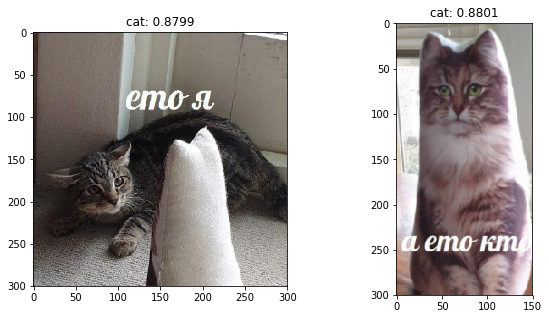

In [62]:
get_label = lambda x: ('cat' if x > 0.5 else 'dog') + ': {:.4f}'.format(x)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(src_1)
plt.title(get_label(score_1))
plt.subplot(122)
plt.imshow(src_2)
plt.title(get_label(score_2))
plt.show()